# Get your check in data from Swarm

### Import Python tools and Jupyter configuration

In [1]:
%load_ext lab_black

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import requests
import json
import sqlite3
from datetime import datetime
import keys

/Users/mhustiles/.local/share/virtualenvs/notebooks-xu8v5Vvv/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [3]:
import altair as alt
import altair_latimes as lat

alt.themes.register("latimes", lat.theme)
alt.themes.enable("latimes")

ThemeRegistry.enable('latimes')

In [4]:
pd.options.display.max_columns = 100
pd.options.display.max_rows = 1000
pd.options.display.max_colwidth = None
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

---

In [5]:
today = datetime.today().strftime("%Y-%m-%d")

### Get the data using this tool from [Swarm-to-SQLite](https://github.com/dogsheep/swarm-to-sqlite)

In [6]:
### Pass in your oauth_token from what you store in keys.py

In [7]:
# !swarm-to-sqlite data/raw/checkins.db --token={keys.TOKEN}

### Read the sqlite database we downloaded

In [8]:
import sqlite3

# Create a SQL connection to our SQLite database
cnx = sqlite3.connect("data/raw/checkins.db")

### Create dataframes for various tables in the DB

In [9]:
venues = pd.read_sql_query("SELECT * FROM venues", cnx)
checkins = pd.read_sql_query("SELECT * FROM checkins", cnx)
categories = pd.read_sql_query("SELECT * FROM categories", cnx)
categories_venues = pd.read_sql_query("SELECT * FROM categories_venues", cnx)

### Merge categories and venues so you can attach categories to the venues in your checkins

In [10]:
category_lookup = pd.merge(
    categories_venues, categories, left_on="categories_id", right_on="id"
)

In [11]:
venue_lookup = pd.merge(categories_venues, venues, left_on="venues_id", right_on="id")

### Merge checkins and venues

In [12]:
src = pd.merge(checkins, venue_lookup, left_on="venue", right_on="id")

In [13]:
df = pd.merge(src, category_lookup, on="venues_id")

### We don't need all the fields

In [14]:
df_slim = df[
    [
        "id_x",
        "timeZoneOffset",
        "isMayor",
        "created",
        "name_x",
        "venue",
        "address",
        "crossStreet",
        "postalCode",
        "city",
        "state",
        "country",
        "latitude",
        "longitude",
        "pluralName",
    ]
].copy()

In [15]:
df_slim.sort_values("created", ascending=False).head()

,id_x,timeZoneOffset,isMayor,created,name_x,venue,address,crossStreet,postalCode,city,state,country,latitude,longitude,pluralName
0,6101f9d78add9779c82228f5,-420,1,2021-07-29T00:44:07,Los Angeles Times,5b4bd8aacad1b60036b3c14f,2300 E Imperial Hwy,Douglas Street,90245,El Segundo,CA,United States,33.930487,-118.382373,Offices
103,6101f9a954e0161522c5a556,-420,0,2021-07-29T00:43:21,Hollywood Sign,5437cf8c498ea44ee25c35ab,None,None,None,Los Angeles,CA,United States,34.102690,-118.339018,Historic Sites
1,6101dc476b9f0f314b54a60d,-420,1,2021-07-28T22:37:59,Los Angeles Times,5b4bd8aacad1b60036b3c14f,2300 E Imperial Hwy,Douglas Street,90245,El Segundo,CA,United States,33.930487,-118.382373,Offices
2,61005d18fd90637440599639,-420,1,2021-07-27T19:23:04,Los Angeles Times,5b4bd8aacad1b60036b3c14f,2300 E Imperial Hwy,Douglas Street,90245,El Segundo,CA,United States,33.930487,-118.382373,Offices
104,61003ed5deefb67430ef15f3,-420,1,2021-07-27T17:13:57,Los Angeles Superior Airport Courthouse,4b1936c1f964a5204fd923e3,11701 S LA Cienega Blvd,None,90045,Los Angeles,CA,United States,33.928316,-118.371332,Courthouses


### Clean up the dates

In [16]:
df_slim["date"] = pd.to_datetime(df_slim["created"], format="%Y-%m-%d")

In [17]:
df_slim["date"] = pd.to_datetime(df_slim["date"].dt.strftime("%Y-%m-%d"))

### Get segments of dates in case we need them for grouping

In [18]:
df_slim["year"] = df_slim["date"].dt.year.astype(str)
df_slim["quarter"] = df_slim["date"].dt.quarter.astype(str)
df_slim["day"] = df_slim["date"].dt.day.astype(str)
df_slim["month"] = df_slim["date"].dt.month.astype(str)
df_slim["weekday"] = df_slim["date"].dt.day_name()
df_slim["monthname"] = df_slim["date"].dt.month_name()
df_slim["monthday"] = df_slim["date"].dt.strftime("%m-%d")
df_slim["monthyear"] = df_slim["date"].dt.strftime("%m-%Y")

### Clean up columns

In [19]:
df_slim.columns = df_slim.columns.str.lower()

In [20]:
df_slim.rename(columns={"id_x": "checkinid", "name_x": "place"}, inplace=True)

---

### Change over time

In [21]:
places_time_grouped = (
    df_slim.groupby(["year"]).agg({"checkinid": "count"}).reset_index()
)

In [22]:
places_time_grouped.rename(columns={"checkinid": "count"}, inplace=True)

In [23]:
places_time_grouped.head(20)

,year,count
0,2010,292
1,2011,538
2,2012,1131
3,2013,683
4,2014,293
5,2015,239
6,2016,419
7,2017,411
8,2018,407
9,2019,624


In [24]:
alt.Chart(places_time_grouped).mark_bar().encode(x="year", y="count").properties(
    width=600, height=400
)

alt.Chart(...)

---

### Venue types

In [25]:
df_slim.sort_values("created", ascending=False).head()

,checkinid,timezoneoffset,ismayor,created,place,venue,address,crossstreet,postalcode,city,state,country,latitude,longitude,pluralname,date,year,quarter,day,month,weekday,monthname,monthday,monthyear
0,6101f9d78add9779c82228f5,-420,1,2021-07-29T00:44:07,Los Angeles Times,5b4bd8aacad1b60036b3c14f,2300 E Imperial Hwy,Douglas Street,90245,El Segundo,CA,United States,33.930487,-118.382373,Offices,2021-07-29,2021,3,29,7,Thursday,July,07-29,07-2021
103,6101f9a954e0161522c5a556,-420,0,2021-07-29T00:43:21,Hollywood Sign,5437cf8c498ea44ee25c35ab,None,None,None,Los Angeles,CA,United States,34.102690,-118.339018,Historic Sites,2021-07-29,2021,3,29,7,Thursday,July,07-29,07-2021
1,6101dc476b9f0f314b54a60d,-420,1,2021-07-28T22:37:59,Los Angeles Times,5b4bd8aacad1b60036b3c14f,2300 E Imperial Hwy,Douglas Street,90245,El Segundo,CA,United States,33.930487,-118.382373,Offices,2021-07-28,2021,3,28,7,Wednesday,July,07-28,07-2021
2,61005d18fd90637440599639,-420,1,2021-07-27T19:23:04,Los Angeles Times,5b4bd8aacad1b60036b3c14f,2300 E Imperial Hwy,Douglas Street,90245,El Segundo,CA,United States,33.930487,-118.382373,Offices,2021-07-27,2021,3,27,7,Tuesday,July,07-27,07-2021
104,61003ed5deefb67430ef15f3,-420,1,2021-07-27T17:13:57,Los Angeles Superior Airport Courthouse,4b1936c1f964a5204fd923e3,11701 S LA Cienega Blvd,None,90045,Los Angeles,CA,United States,33.928316,-118.371332,Courthouses,2021-07-27,2021,3,27,7,Tuesday,July,07-27,07-2021


In [26]:
venues_grouped = (
    df_slim.groupby(["pluralname"])
    .agg({"checkinid": "count"})
    .reset_index()
    .sort_values("checkinid", ascending=False)
)

In [27]:
venues_grouped.rename(columns={"checkinid": "count"}, inplace=True)

In [28]:
venues_grouped.head()

,pluralname,count
215,Offices,597
72,Coffee Shops,430
5,Airports,330
193,Metro Stations,232
112,Event Spaces,210


---

### Countries

In [29]:
countries_grouped = (
    df_slim.groupby(["country"])
    .agg({"checkinid": "count"})
    .reset_index()
    .sort_values("checkinid", ascending=False)
)

In [30]:
countries_grouped.rename(columns={"checkinid": "count"}, inplace=True)

In [31]:
countries_grouped.head()

,country,count
26,United States,3961
21,South Korea,1053
23,Taiwan,55
14,Japan,29
11,Ireland,29


---

### Make it a geodataframe

In [32]:
gdf = gpd.GeoDataFrame(
    df_slim, geometry=gpd.points_from_xy(df_slim.longitude, df_slim.latitude)
)

<AxesSubplot:>

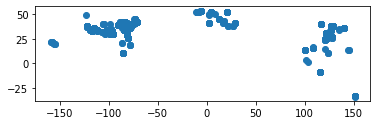

In [33]:
gdf.plot()

### Export

In [34]:
df.to_json("data/processed/checkins.json", orient="records", indent=4)

In [35]:
gdf.to_file("data/processed/geo_checkins.json", driver="GeoJSON")